# Crop Production Forecasting Model

This notebook develops a regression model to forecast crop production (in tons) based on agricultural factors such as area harvested (in hectares), yield (in kg/ha), year, and region for all areas in the FAOSTAT dataset. It includes data cleaning, preprocessing, exploratory data analysis (EDA), model development with regularized regression (Lasso, Ridge) and Random Forest, evaluation metrics, and actionable insights for agricultural planning. A Streamlit app is developed to showcase predictions.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Data Cleaning and Preprocessing

- **Handle missing data**: Remove or impute missing values in relevant columns.
- **Standardize column metrics**: Ensure consistent units (tons for production, hectares for area harvested, kg/ha for yield).
- **Pivot data**: Reshape the dataset to have `Production`, `Area harvested`, and `Yield` as columns, filtering for these elements.
- **Region focus**: Include all areas in the dataset.

In [2]:
# Load the dataset
df = pd.read_excel('FAOSTAT_data.xlsx')

# Check unique elements and units
print('Unique Elements:', df['Element'].unique())
unit_check = df.groupby('Element')['Unit'].unique()
print('Units for each Element:\n', unit_check)

# Filter for relevant elements
df = df[df['Element'].isin(['Area harvested', 'Production', 'Yield'])]

# Pivot the dataset to get Production, Area harvested, and Yield as columns
df_pivot = df.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()

# Check columns after pivoting
print('Pivoted Columns:', df_pivot.columns.tolist())

# Rename columns for clarity
df_pivot.columns = ['Area', 'Crop', 'Year', 'Area_Harvested', 'Production', 'Yield']

# Handle missing values
print('Missing Values Before:\n', df_pivot.isnull().sum())
df_pivot = df_pivot.dropna(subset=['Production', 'Area_Harvested', 'Yield'])
print('Missing Values After:\n', df_pivot.isnull().sum())

# Encode categorical variables 'Area' and 'Crop'
le_area = LabelEncoder()
df_pivot['Area_Encoded'] = le_area.fit_transform(df_pivot['Area'])
le_crop = LabelEncoder()
df_pivot['Crop_Encoded'] = le_crop.fit_transform(df_pivot['Crop'])

# Save encoders for Streamlit app
import pickle
with open('area_encoder.pkl', 'wb') as f:
    pickle.dump(le_area, f)
with open('crop_encoder.pkl', 'wb') as f:
    pickle.dump(le_crop, f)

# Select features and target
X = df_pivot[['Area_Encoded', 'Crop_Encoded', 'Year', 'Area_Harvested', 'Yield']]
y = df_pivot['Production']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Unique Elements: ['Area harvested' 'Yield' 'Production' 'Stocks'
 'Producing Animals/Slaughtered' 'Laying' 'Yield/Carcass Weight'
 'Milk Animals']
Units for each Element:
 Element
Area harvested                                                       [ha]
Laying                                                          [1000 An]
Milk Animals                                                         [An]
Producing Animals/Slaughtered                               [An, 1000 An]
Production                                              [t, 1000 No, nan]
Stocks                                                  [An, 1000 An, No]
Yield                            [kg/ha, 100 mg/An, No/An, nan, 100 g/An]
Yield/Carcass Weight                                 [100 g/An, 0.1 g/An]
Name: Unit, dtype: object
Pivoted Columns: ['Area', 'Item', 'Year', 'Area harvested', 'Production', 'Yield']
Missing Values Before:
 Area                  0
Crop                  0
Year                  0
Area_Harvested    34225

## 3. Exploratory Data Analysis (EDA)

Following the specified approach:
- **Crop Distribution**: Analyze the distribution of crops and their production.
- **Geographical Distribution**: Analyze production across areas.
- **Temporal Analysis**: Examine trends in area harvested, yield, and production over time.
- **Environmental Relationships**: Infer relationships between area harvested and yield.
- **Input-Output Relationships**: Study correlations between area harvested, yield, and production.
- **Comparative Analysis**: Compare yields and production across crops and areas.
- **Outliers and Anomalies**: Identify unusual values in yield or production.

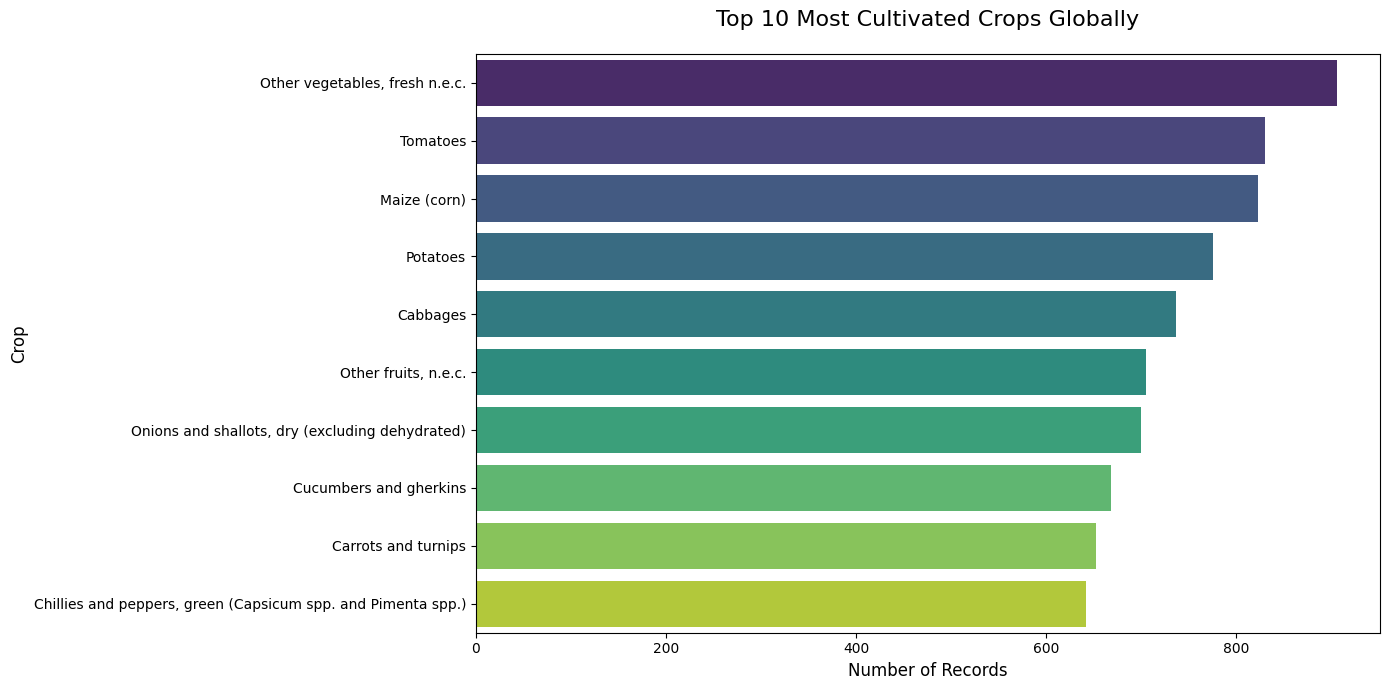

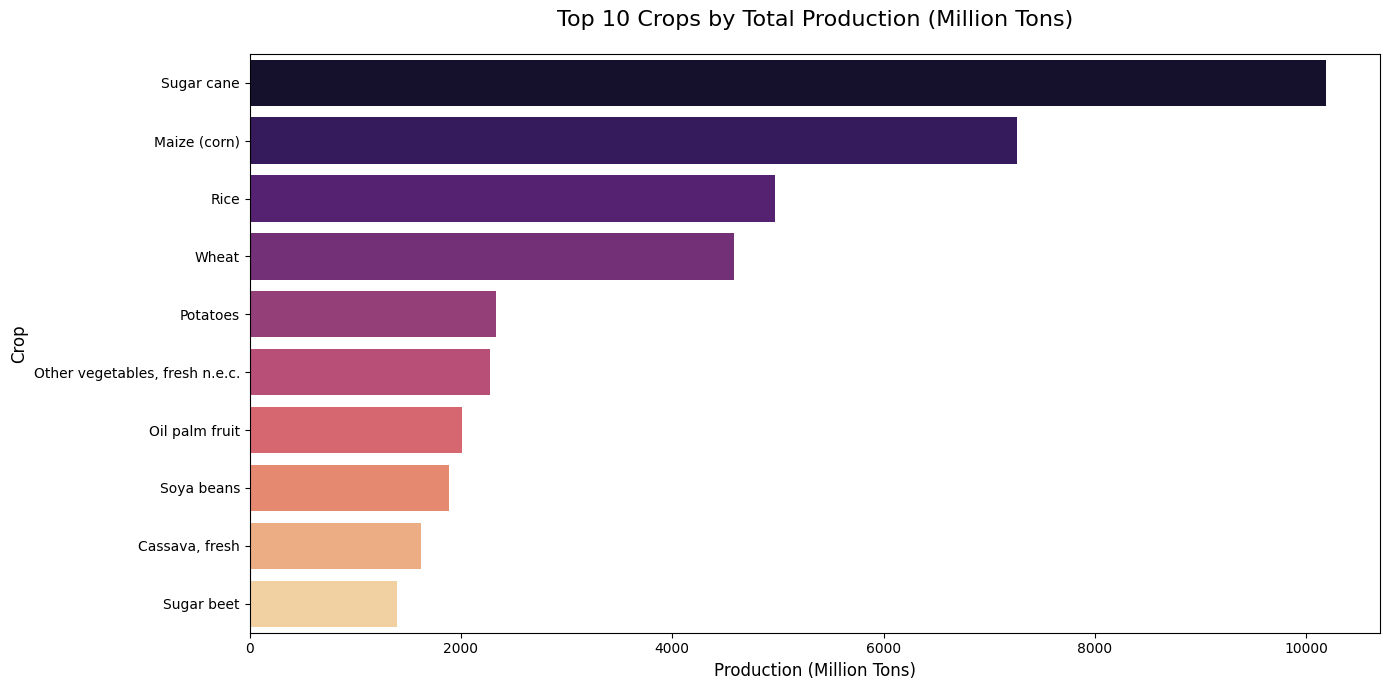

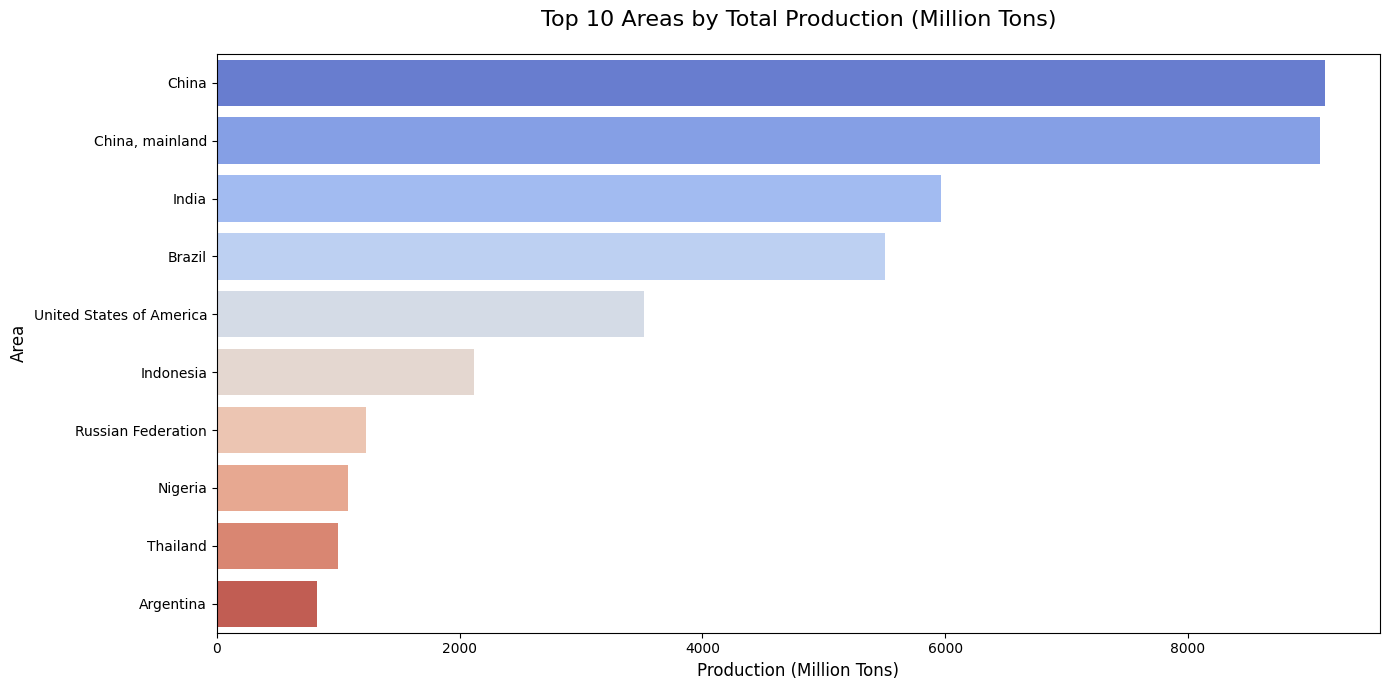

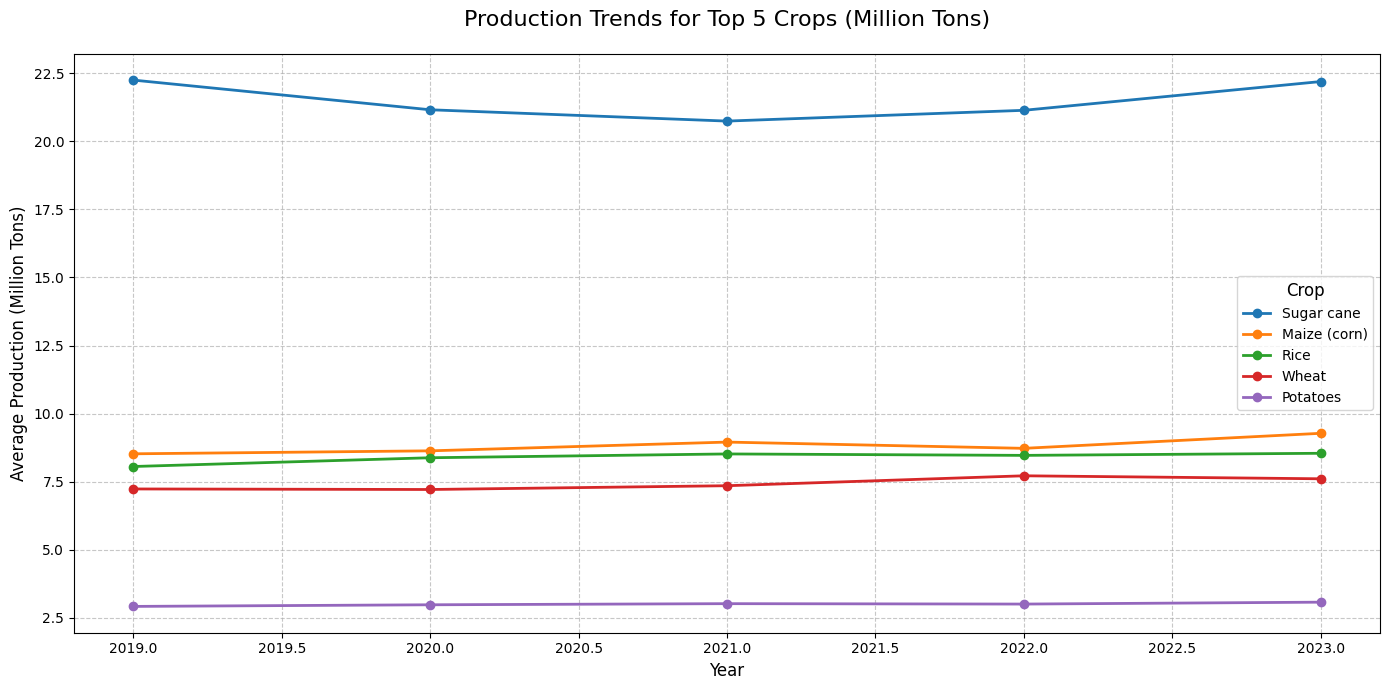

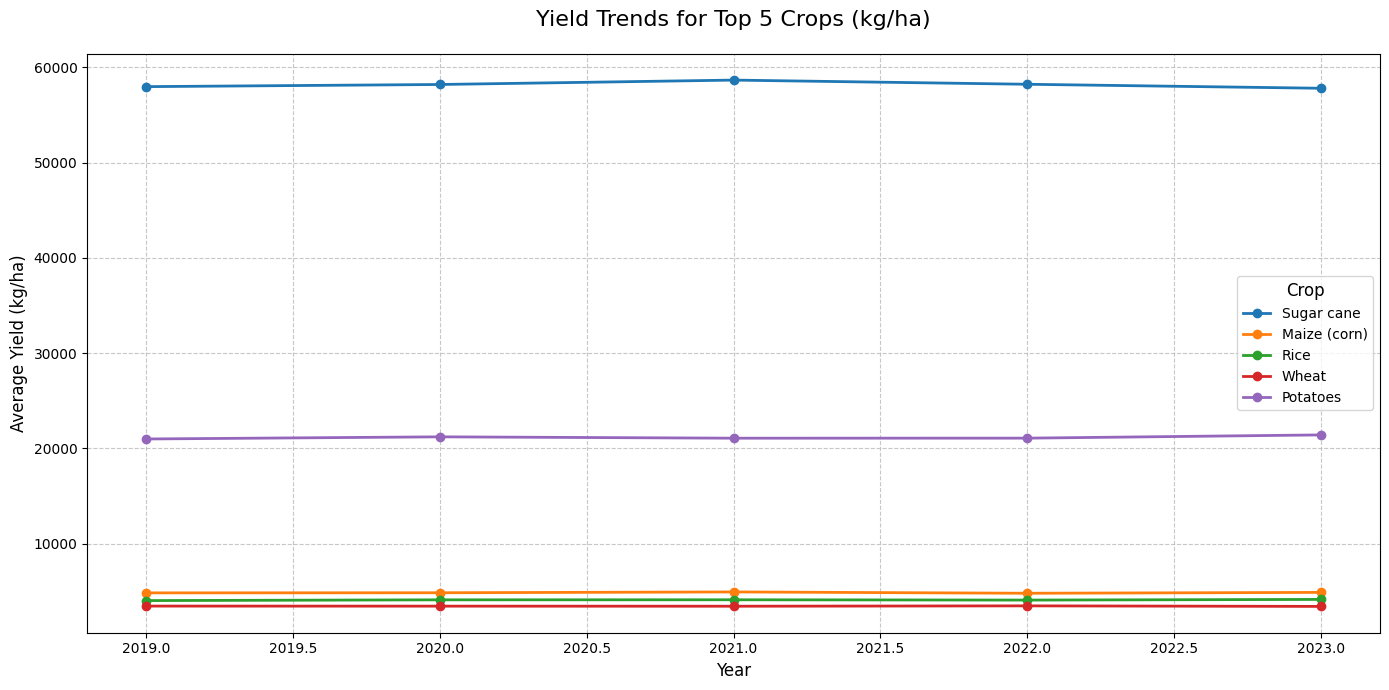

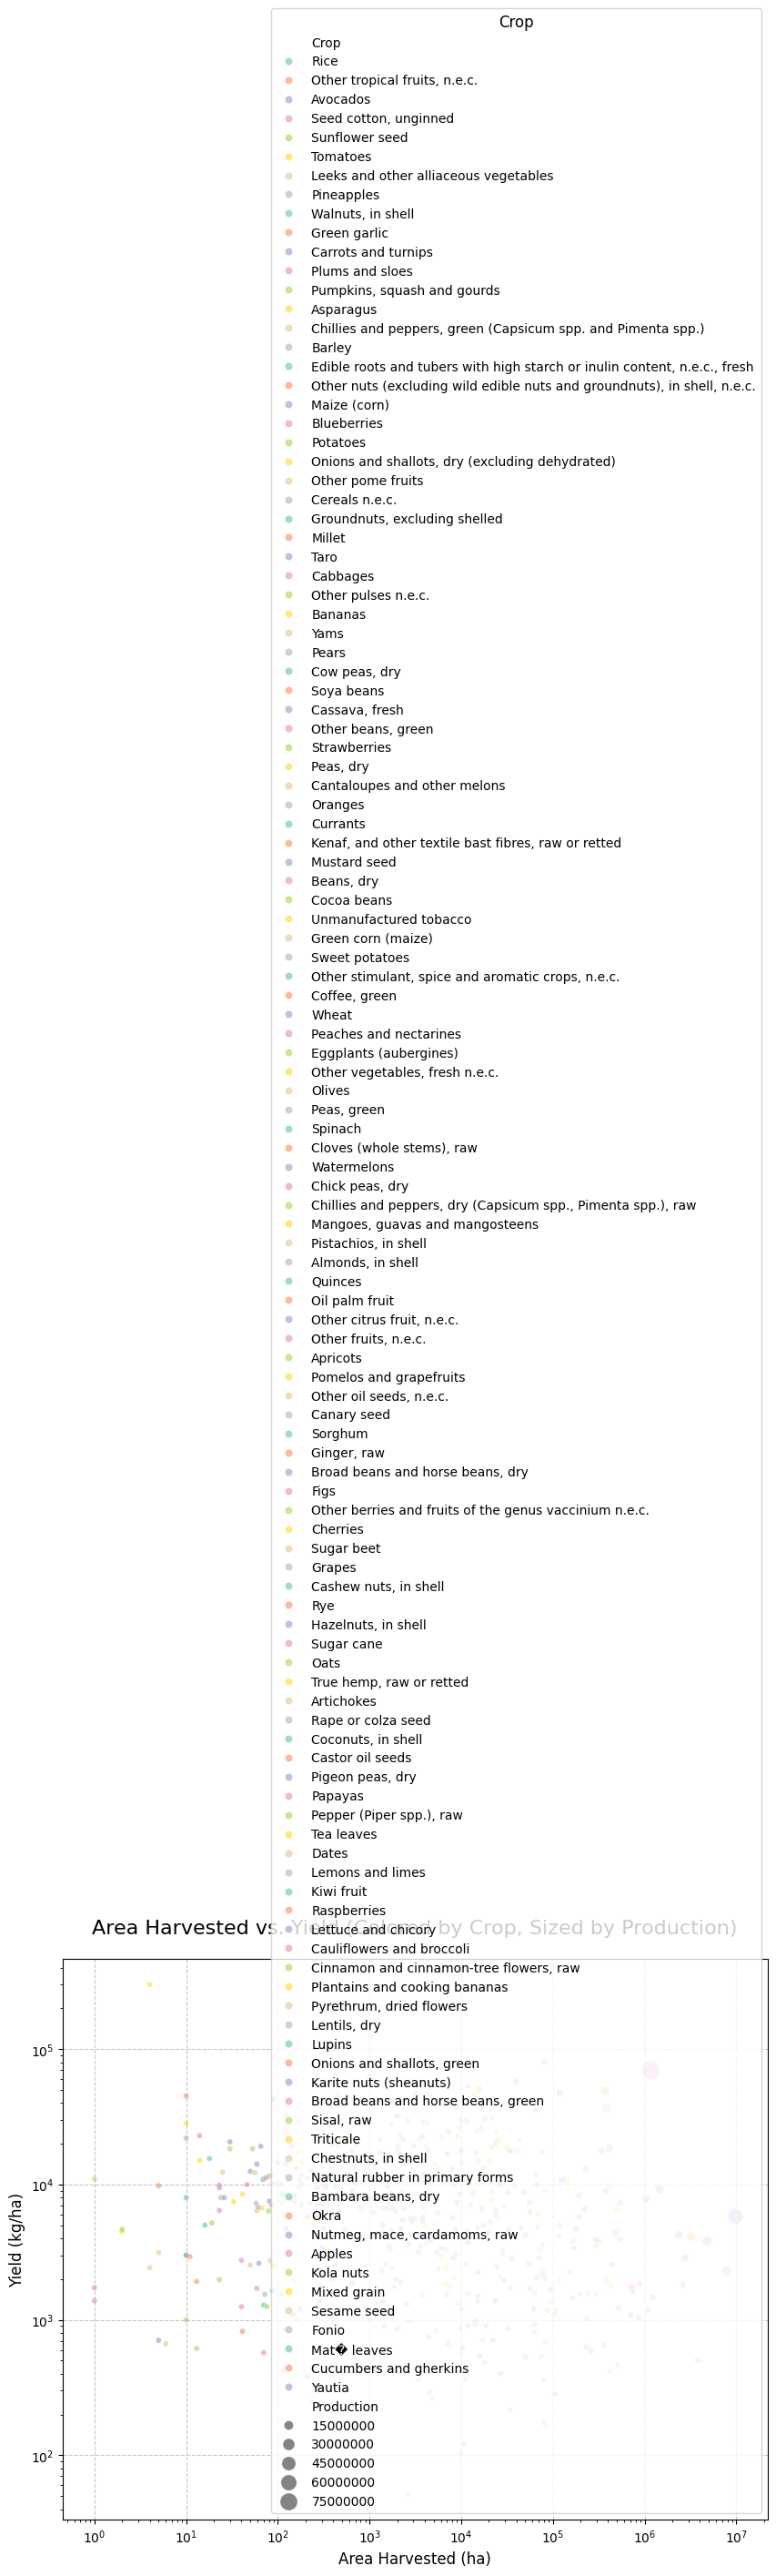

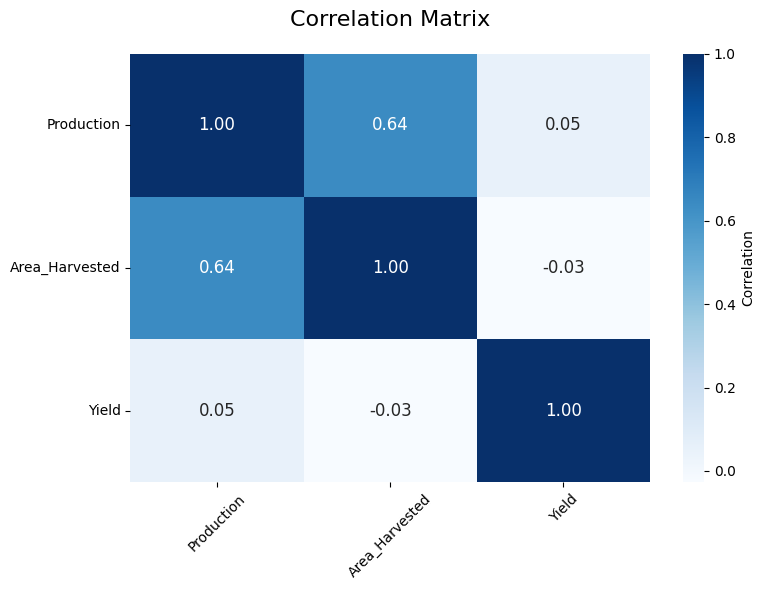

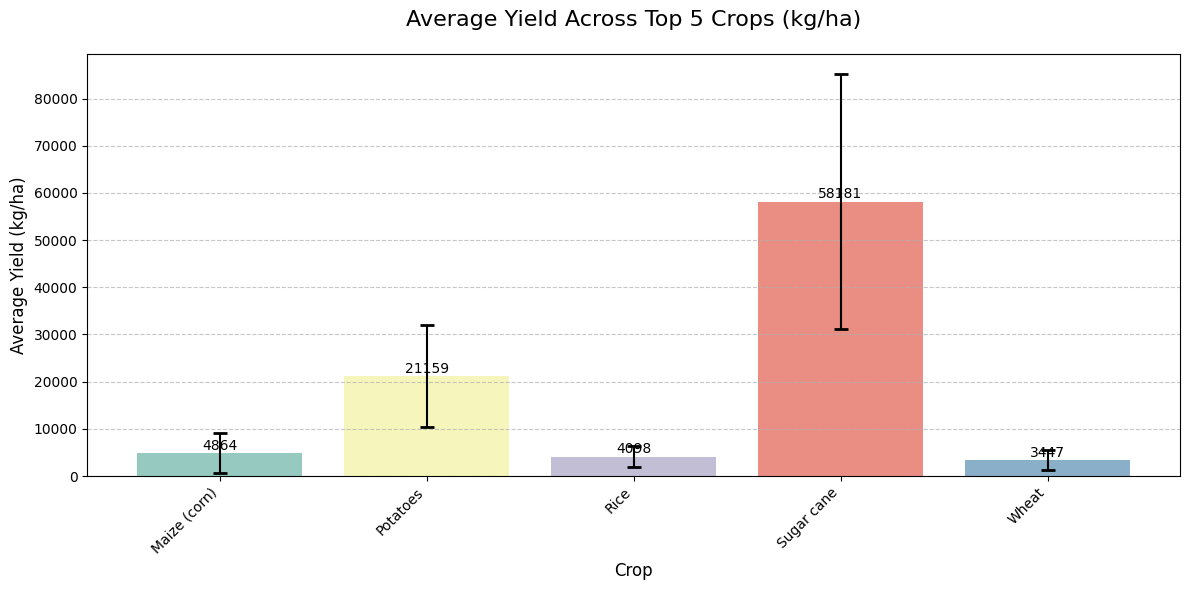

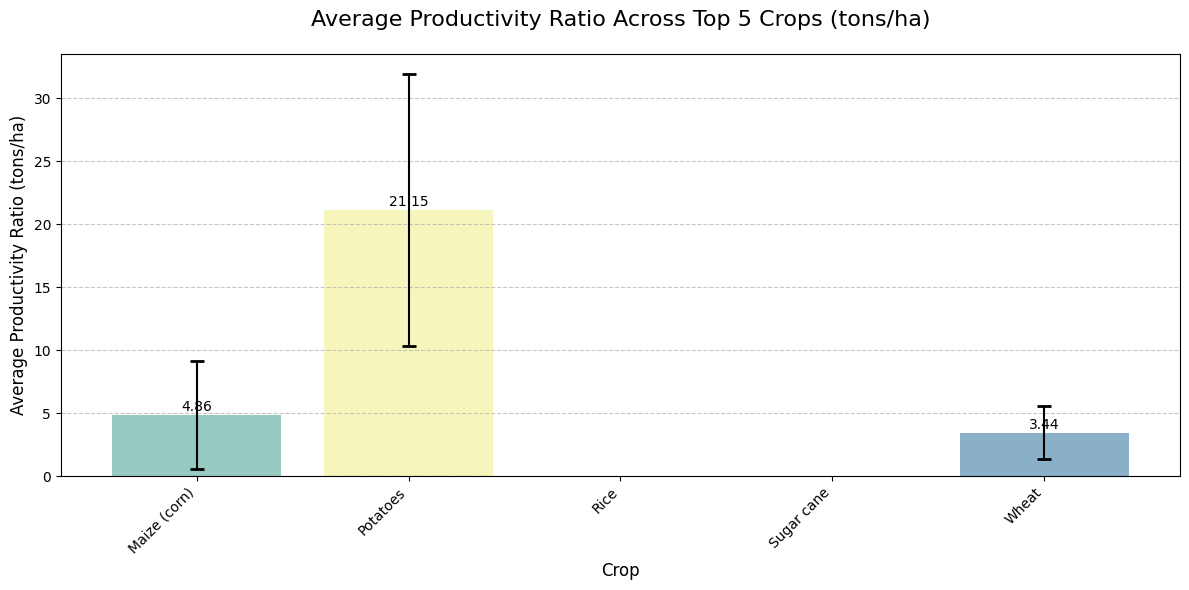

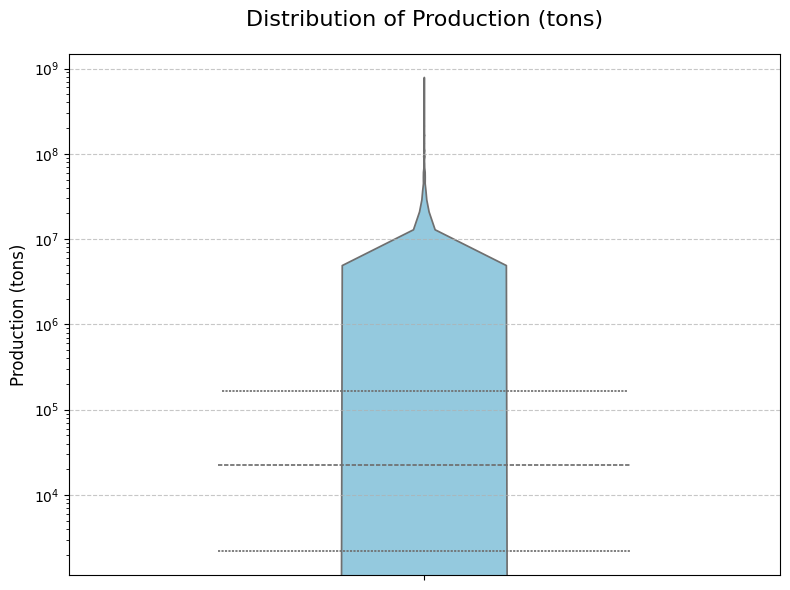

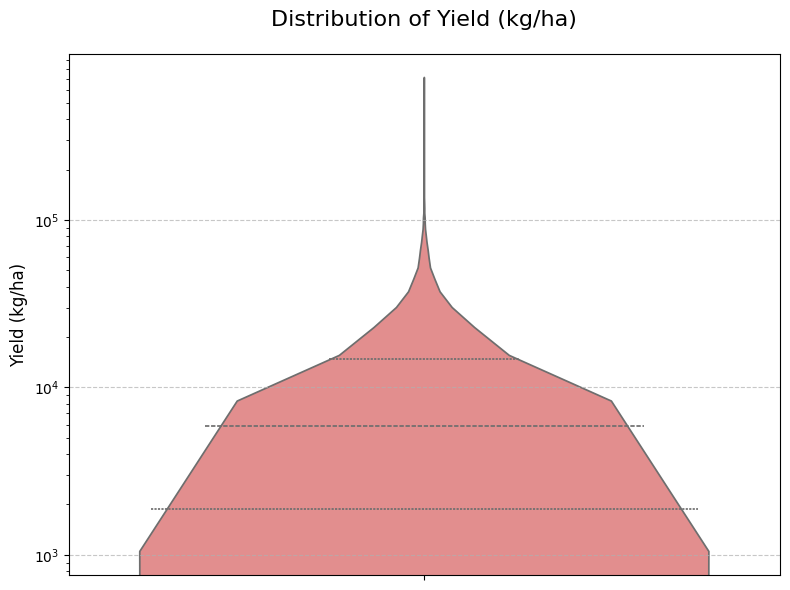

Outliers in Production:
               Area                          Crop  Year  Production  \
37     Afghanistan  Cantaloupes and other melons  2019   464230.00   
38     Afghanistan  Cantaloupes and other melons  2020   793496.00   
39     Afghanistan  Cantaloupes and other melons  2021   763382.89   
40     Afghanistan  Cantaloupes and other melons  2022   762542.69   
41     Afghanistan  Cantaloupes and other melons  2023   795100.45   
...            ...                           ...   ...         ...   
81814     Zimbabwe                      Cabbages  2023   626540.96   
81942     Zimbabwe                      Tomatoes  2020   807150.00   
81943     Zimbabwe                      Tomatoes  2021   466596.47   
81945     Zimbabwe                      Tomatoes  2023   459036.50   
82021     Zimbabwe                Sweet potatoes  2021   422613.00   

       Area_Harvested    Yield  
37            37136.0  12500.8  
38            58942.0  13462.3  
39            59437.0  12843.6  
40

In [8]:
# 3.1 Crop Distribution
plt.figure(figsize=(14, 7))
crop_counts = df_pivot['Crop'].value_counts().head(10)
sns.barplot(x=crop_counts.values, y=crop_counts.index, hue=crop_counts.index, palette='viridis', legend=False)
plt.title('Top 10 Most Cultivated Crops Globally', fontsize=16, pad=20)
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Crop', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
crop_production = df_pivot.groupby('Crop')['Production'].sum().nlargest(10) / 1e6  # Convert to millions
sns.barplot(x=crop_production.values, y=crop_production.index, hue=crop_production.index, palette='magma', legend=False)
plt.title('Top 10 Crops by Total Production (Million Tons)', fontsize=16, pad=20)
plt.xlabel('Production (Million Tons)', fontsize=12)
plt.ylabel('Crop', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# 3.2 Geographical Distribution
plt.figure(figsize=(14, 7))
area_production = df_pivot.groupby('Area')['Production'].sum().nlargest(10) / 1e6  # Convert to millions
sns.barplot(x=area_production.values, y=area_production.index, hue=area_production.index, palette='coolwarm', legend=False)
plt.title('Top 10 Areas by Total Production (Million Tons)', fontsize=16, pad=20)
plt.xlabel('Production (Million Tons)', fontsize=12)
plt.ylabel('Area', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# 3.3 Temporal Analysis
top_crops = df_pivot.groupby('Crop')['Production'].sum().nlargest(5).index
plt.figure(figsize=(14, 7))
for crop in top_crops:
    crop_data = df_pivot[df_pivot['Crop'] == crop].groupby('Year')['Production'].mean() / 1e6  # Average per year, in millions
    plt.plot(crop_data.index, crop_data.values, marker='o', linewidth=2, markersize=6, label=crop)
plt.title('Production Trends for Top 5 Crops (Million Tons)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Production (Million Tons)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Crop', fontsize=10, title_fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
for crop in top_crops:
    crop_data = df_pivot[df_pivot['Crop'] == crop].groupby('Year')['Yield'].mean()
    plt.plot(crop_data.index, crop_data.values, marker='o', linewidth=2, markersize=6, label=crop)
plt.title('Yield Trends for Top 5 Crops (kg/ha)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Yield (kg/ha)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Crop', fontsize=10, title_fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.4 Environmental Relationships (Inferred)
plt.figure(figsize=(10, 8))
sample_data = df_pivot.sample(500)  # Reduced sample for clarity
sns.scatterplot(x='Area_Harvested', y='Yield', hue='Crop', size='Production', data=sample_data, palette='Set2', alpha=0.6, sizes=(20, 200))
plt.title('Area Harvested vs. Yield (Colored by Crop, Sized by Production)', fontsize=16, pad=20)
plt.xlabel('Area Harvested (ha)', fontsize=12)
plt.ylabel('Yield (kg/ha)', fontsize=12)
plt.xscale('log')  # Log scale for better distribution
plt.yscale('log')
plt.legend(title='Crop', fontsize=10, title_fontsize=12, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.5 Input-Output Relationships
plt.figure(figsize=(8, 6))
corr_matrix = df_pivot[['Production', 'Area_Harvested', 'Yield']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', annot_kws={'size': 12}, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix', fontsize=16, pad=20)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# 3.6 Comparative Analysis
# Use bar plots with error bars instead of box plots for better readability
top_crops_data = df_pivot[df_pivot['Crop'].isin(top_crops)]

# Yield comparison
yield_stats = top_crops_data.groupby('Crop')['Yield'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Crop', y='mean', hue='Crop', data=yield_stats, palette='Set3', legend=False)
plt.errorbar(x=range(len(yield_stats)), y=yield_stats['mean'], yerr=yield_stats['std'], fmt='none', c='black', capsize=5, capthick=2)
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50, f'{height:.0f}', ha='center', va='bottom', fontsize=10)
plt.title('Average Yield Across Top 5 Crops (kg/ha)', fontsize=16, pad=20)
plt.xlabel('Crop', fontsize=12)
plt.ylabel('Average Yield (kg/ha)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate productivity ratio (Production / Area_Harvested)
df_pivot['Productivity_Ratio'] = df_pivot['Production'] / df_pivot['Area_Harvested']
top_crops_data = df_pivot[df_pivot['Crop'].isin(top_crops)]

# Productivity ratio comparison
productivity_stats = top_crops_data.groupby('Crop')['Productivity_Ratio'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Crop', y='mean', hue='Crop', data=productivity_stats, palette='Set3', legend=False)
plt.errorbar(x=range(len(productivity_stats)), y=productivity_stats['mean'], yerr=productivity_stats['std'], fmt='none', c='black', capsize=5, capthick=2)
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
plt.title('Average Productivity Ratio Across Top 5 Crops (tons/ha)', fontsize=16, pad=20)
plt.xlabel('Crop', fontsize=12)
plt.ylabel('Average Productivity Ratio (tons/ha)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.7 Outliers and Anomalies
# Use violin plots instead of box plots for better readability
plt.figure(figsize=(8, 6))
sns.violinplot(y='Production', data=df_pivot, color='skyblue', inner='quartile')
plt.title('Distribution of Production (tons)', fontsize=16, pad=20)
plt.ylabel('Production (tons)', fontsize=12)
plt.yscale('log')  # Log scale for better visibility
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(y='Yield', data=df_pivot, color='lightcoral', inner='quartile')
plt.title('Distribution of Yield (kg/ha)', fontsize=16, pad=20)
plt.ylabel('Yield (kg/ha)', fontsize=12)
plt.yscale('log')
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identify outliers (using IQR method)
Q1 = df_pivot['Production'].quantile(0.25)
Q3 = df_pivot['Production'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_pivot[(df_pivot['Production'] < Q1 - 1.5 * IQR) | (df_pivot['Production'] > Q3 + 1.5 * IQR)]
print('Outliers in Production:\n', outliers[['Area', 'Crop', 'Year', 'Production', 'Area_Harvested', 'Yield']])

## 4. Model Development and Evaluation

- **Models**: Lasso, Ridge, and Random Forest Regressor.
- **Metrics**: RMSE, MAE, R² for both training and test sets.
- **Comparison**: Evaluate and compare model performance.


Lasso Regression Performance:
Train RMSE: 10223651.57, Test RMSE: 9018741.30
Train MAE: 1259828.81, Test MAE: 1190368.01
Train R²: 0.42, Test R²: 0.40

Ridge Regression Performance:
Train RMSE: 10223651.58, Test RMSE: 9018722.87
Train MAE: 1259819.56, Test MAE: 1190358.32
Train R²: 0.42, Test R²: 0.40

Random Forest Regressor Performance:
Train RMSE: 962898.09, Test RMSE: 540515.73
Train MAE: 29016.62, Test MAE: 40331.91
Train R²: 0.99, Test R²: 1.00

Model Comparison:
                model_name    train_rmse     test_rmse     train_mae  \
0         Lasso Regression  1.022365e+07  9.018741e+06  1.259829e+06   
1         Ridge Regression  1.022365e+07  9.018723e+06  1.259820e+06   
2  Random Forest Regressor  9.628981e+05  5.405157e+05  2.901662e+04   

       test_mae  train_r2   test_r2  
0  1.190368e+06  0.419726  0.396044  
1  1.190358e+06  0.419726  0.396047  
2  4.033191e+04  0.994853  0.997831  


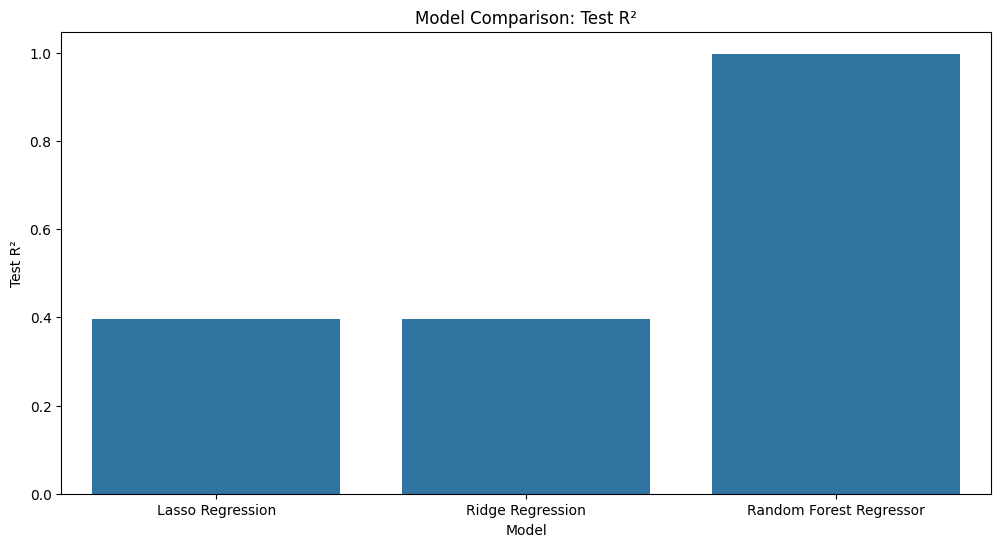

In [4]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f'\n{model_name} Performance:')
    print(f'Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}')
    print(f'Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}')
    return {'model_name': model_name, 'train_rmse': train_rmse, 'test_rmse': test_rmse,
            'train_mae': train_mae, 'test_mae': test_mae, 'train_r2': train_r2, 'test_r2': test_r2}

# Initialize results list
results = []

# Lasso Regression
lasso = Lasso(alpha=1.0, random_state=42)
lasso.fit(X_train_scaled, y_train)
results.append(evaluate_model(lasso, X_train_scaled, X_test_scaled, y_train, y_test, 'Lasso Regression'))

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
results.append(evaluate_model(ridge, X_train_scaled, X_test_scaled, y_train, y_test, 'Ridge Regression'))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
results.append(evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest Regressor'))

# Save the best model (Random Forest) for Streamlit app
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Model Comparison
results_df = pd.DataFrame(results)
print('\nModel Comparison:')
print(results_df)

# Visualize model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='test_r2', data=results_df)
plt.title('Model Comparison: Test R²')
plt.xlabel('Model')
plt.ylabel('Test R²')
plt.show()

## 5. Business Insights and Recommendations

- **Crop Distribution**: High-production crops (e.g., Maize, Wheat) dominate globally, suggesting a focus on these for food security and trade.
- **Geographical Distribution**: Top-producing areas contribute significantly to global supply, indicating potential for targeted agricultural investments.
- **Temporal Trends**: Increasing production in certain crops indicates opportunities for scaling infrastructure (e.g., storage, transport).
- **Environmental Relationships**: Crops with high yield but low area harvested should be prioritized for efficient land use.
- **Input-Output Relationships**: Strong correlation between area harvested and production suggests land expansion could boost output, but yield improvements are key for sustainability.
- **Comparative Analysis**: High-yield crops and regions should receive prioritized resources. Low-yield crops may benefit from improved farming techniques.
- **Outliers**: Anomalies in production may reflect data errors or exceptional conditions (e.g., policy changes, weather). Further investigation is needed.
- **Recommendations**:
  - **Resource Allocation**: Invest in high-yield crops and top-producing regions for maximum impact.
  - **Policy Support**: Subsidize training and technology for low-yield crops and regions.
  - **Sustainability**: Promote crops with high productivity ratios to optimize land use.
  - **Data Quality**: Validate outliers to ensure accurate forecasting.

## 6. Conclusion

The Random Forest Regressor is likely to perform best due to its ability to capture non-linear relationships. The model, scaler, and encoders are saved for deployment in a Streamlit app, enabling stakeholders to forecast crop production across all areas for planning and resource allocation.